## Introduction ##

In this dataset which contains major power outage data from the US from 2000 through 2016, the characteristics of major outages are analyzed and a model is created using pipelines and lienar regression to predict the severity of a major power outage. The duration of time of major power outages is used as the target variable for predicting based on other columns in the data given such as the climate and the amount of customers affected. This prediction is a regression problem since predicting the duration of time is quantitative and so the objective would be to minimize the root-mean squared error (RMSE). The goal is to have a final model with a lower RMSE than the baseline model. The f1-score would not be an appropriate measure for accuracy for this model because it would be nearly impossible to predict the exact continuous values without transforming the duration column into categorical data, where each category is a range of values. Therefore, the f1-score is not used in this model.

## Baseline Model ##

For the baseline model, five columns are chosen and therefore five features are included to try to predict the duration of major power outages including: 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW', 'CLIMATE.CATEGORY', 'CLIMATE.REGION', and 'MONTH'. The two numerical categories, 'CUSTOMERS.AFFECTED' and 'DEMAND.LOSS.MW', are both like 'OUTAGE.DURATION' in that they relate to the extent of outages. The other three categories are all categorical, so one-hot encoding was used for each. The 'MONTH' column was one-hot encoded instead of using ordinal encoding since the month December does not have a larger magnitude than January based on month alone. The RMSE and R^2 values are useful predictors for the performance of this model. The goal is to find the highest R^2 value and the lowest RMSE to find the measure of the differences between nominal values of the predicted data and the test data.

## Final Model ##

For the model selection of the final model, train-test split was used as it randomizes the data that is used to avoid biases and it helps train the model as accurately as possible. Principal component analysis (PCA) and standard scaler were used on the two additional features to help the model perform better. PCA was used to minimize potential correlation between the different components and to explain as much variance in the outcome variable as possible. Standard scaler was used for the numerical columns to account for the outliers (0 and extremely large numbers) which may skew the data that are to be evaluated. While these two features did noticeably improve the model, the model still had a lower prediction score which is likely due to the fact that the duration of a power outage is dependent on many other factors such as the availability of mechanics to fix the outage and the complexity of the electrical grids, which are not included in the dataset. A power outage could be longer because there is not as much manpower to fix the outage. 

## Fairness Evaluation ##

For the fairness evaluation, the months when the major power outages occur are investigated for their effect on the prediction. With RMSE as the parity measure, the goal is to get the least amount of error as possible. If one model has a higher RMSE than the other, then the model is biased towards the first subset. Permutation test is also used to see the difference between months. The null hypothesis is that there is no difference between the fall months and the other months; all months are equal. On the other hand, the alternative hypothesis is that there is a difference between fall months and other months.  

## Setup ##

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Higher resolution figures

Some of the imports were not used in the final model but considered in feature engineering.

In [4]:
import datetime
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

## Data Cleaning ##

This code reads the excel file "outage" and sets it to variable "outage".

In [8]:
outage = pd.read_excel('outage.xlsx')

For the first part of cleaning the dataframe, the first 4 rows are removed as they aren't actual data. Then, the columns are set as the variable names, and set 'OBS' as the index.

In [10]:
columns = outage.iloc[4].values
outage.columns = columns
outage = outage.drop([0,1,2,3,4,5])
outage = outage.set_index(outage['OBS'])
outage = outage.drop(columns='variables')
outage = outage.drop(columns ='OBS')
outage.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


This code creates the new columns "OUTAGE.RESTORATION" and "OUTAGE.START".

In [14]:
def turntostring(row):
    return str(row['OUTAGE.START.DATE'])
def turntostring2(row):
    return str(row['OUTAGE.START.TIME'])
def fixstart(row):
    new = row['OUTAGE.START.DATE'].replace('00:00:00', row['OUTAGE.START.TIME'])
    return new
outage['OUTAGE.START.DATE'] = outage.apply(turntostring, axis=1)
outage['OUTAGE.START.TIME'] = outage.apply(turntostring2, axis=1)
outage['OUTAGE.START'] = outage.apply(fixstart,axis=1)
outage['OUTAGE.START'] = pd.to_datetime(outage['OUTAGE.START'])
outage['OUTAGE.START'].head()

def turntostring3(row):
    return str(row['OUTAGE.RESTORATION.DATE'])
def turntostring4(row):
    return str(row['OUTAGE.RESTORATION.TIME'])
def fixrestoration(row):
    new = row['OUTAGE.RESTORATION.DATE'].replace('00:00:00', row['OUTAGE.RESTORATION.TIME'])
    return new

outage['OUTAGE.RESTORATION.DATE'] = outage.apply(turntostring3, axis=1)
outage['OUTAGE.RESTORATION.TIME'] = outage.apply(turntostring4, axis=1)
outage['OUTAGE.RESTORATION'] = outage.apply(fixrestoration,axis=1)
outage['OUTAGE.RESTORATION'] = pd.to_datetime(outage['OUTAGE.RESTORATION'])

print(outage['OUTAGE.START'].head())
print(outage['OUTAGE.RESTORATION'].head())

OBS
1   2011-07-01 17:00:00
2   2014-05-11 18:38:00
3   2010-10-26 20:00:00
4   2012-06-19 04:30:00
5   2015-07-18 02:00:00
Name: OUTAGE.START, dtype: datetime64[ns]
OBS
1   2011-07-03 20:00:00
2   2014-05-11 18:39:00
3   2010-10-28 22:00:00
4   2012-06-20 23:00:00
5   2015-07-19 07:00:00
Name: OUTAGE.RESTORATION, dtype: datetime64[ns]


## Baseline Model ##

Because all of the datatypes of the dataframe are of type "object", The following code changes the
data types of each column to their appropriate column so then they can be utilized in the pipeline easier.

In [15]:
outage['MONTH'] = outage['MONTH'].astype(str)
outage['YEAR'] = outage['YEAR'].astype(str)
outage['OUTAGE.START.TIME'] = pd.to_datetime(outage['OUTAGE.START.TIME'])
outage['OUTAGE.START.DATE'] = pd.to_datetime(outage['OUTAGE.START.DATE'])
outage['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(outage['OUTAGE.RESTORATION.DATE'])
outage['OUTAGE.RESTORATION.TIME'] = pd.to_datetime(outage['OUTAGE.RESTORATION.TIME'])
outage['ANOMALY.LEVEL'] = pd.to_numeric(outage['ANOMALY.LEVEL'])
outage['OUTAGE.DURATION'] = pd.to_numeric(outage['OUTAGE.DURATION'])
outage['DEMAND.LOSS.MW'] = pd.to_numeric(outage['DEMAND.LOSS.MW'])
outage['CUSTOMERS.AFFECTED'] = pd.to_numeric(outage['CUSTOMERS.AFFECTED'])
outage['RES.PRICE'] = pd.to_numeric(outage['RES.PRICE'])
outage['COM.PRICE'] = pd.to_numeric(outage['COM.PRICE'])
outage['IND.PRICE'] = pd.to_numeric(outage['IND.PRICE'])
outage['TOTAL.PRICE'] = pd.to_numeric(outage['TOTAL.PRICE'])
outage['RES.SALES'] = pd.to_numeric(outage['RES.SALES'])
outage['COM.SALES'] = pd.to_numeric(outage['COM.SALES'])
outage['IND.SALES'] = pd.to_numeric(outage['IND.SALES'])
outage['TOTAL.SALES'] = pd.to_numeric(outage['TOTAL.SALES'])
outage['RES.PERCEN'] = pd.to_numeric(outage['RES.PERCEN'])
outage['COM.PERCEN'] = pd.to_numeric(outage['COM.PERCEN'])
outage['IND.PERCEN'] = pd.to_numeric(outage['IND.PERCEN'])
outage['RES.CUSTOMERS'] = pd.to_numeric(outage['RES.CUSTOMERS'])
outage['COM.CUSTOMERS'] = pd.to_numeric(outage['COM.CUSTOMERS'])
outage['IND.CUSTOMERS'] = pd.to_numeric(outage['IND.CUSTOMERS'])
outage['TOTAL.CUSTOMERS'] = pd.to_numeric(outage['TOTAL.CUSTOMERS'])
outage['RES.CUST.PCT'] = pd.to_numeric(outage['RES.CUST.PCT'])
outage['COM.CUST.PCT'] = pd.to_numeric(outage['COM.CUST.PCT'])
outage['IND.CUST.PCT'] = pd.to_numeric(outage['IND.CUST.PCT'])
outage['PC.REALGSP.STATE'] = pd.to_numeric(outage['PC.REALGSP.STATE'])
outage['PC.REALGSP.USA'] = pd.to_numeric(outage['PC.REALGSP.USA'])
outage['PC.REALGSP.REL'] = pd.to_numeric(outage['PC.REALGSP.REL'])
outage['PC.REALGSP.CHANGE'] = pd.to_numeric(outage['PC.REALGSP.CHANGE'])
outage['UTIL.REALGSP'] = pd.to_numeric(outage['UTIL.REALGSP'])
outage['TOTAL.REALGSP'] = pd.to_numeric(outage['TOTAL.REALGSP'])
outage['UTIL.CONTRI'] = pd.to_numeric(outage['UTIL.CONTRI'])
outage['PI.UTIL.OFUSA'] = pd.to_numeric(outage['PI.UTIL.OFUSA'])
outage['POPULATION'] = pd.to_numeric(outage['POPULATION'])
outage['POPPCT_URBAN'] = pd.to_numeric(outage['POPPCT_URBAN'])
outage['POPPCT_UC'] = pd.to_numeric(outage['POPPCT_UC'])
outage['POPDEN_URBAN'] = pd.to_numeric(outage['POPDEN_URBAN'])
outage['POPDEN_UC'] = pd.to_numeric(outage['POPDEN_UC'])
outage['POPDEN_RURAL'] = pd.to_numeric(outage['POPDEN_RURAL'])
outage['AREAPCT_URBAN'] = pd.to_numeric(outage['AREAPCT_URBAN'])
outage['AREAPCT_UC'] = pd.to_numeric(outage['AREAPCT_UC'])
outage['PCT_LAND'] = pd.to_numeric(outage['PCT_LAND'])
outage['PCT_WATER_TOT'] = pd.to_numeric(outage['PCT_WATER_TOT'])
outage['PCT_WATER_INLAND'] = pd.to_numeric(outage['PCT_WATER_INLAND'])
                                                          
outage.dtypes

YEAR                               object
MONTH                              object
U.S._STATE                         object
POSTAL.CODE                        object
NERC.REGION                        object
CLIMATE.REGION                     object
ANOMALY.LEVEL                     float64
CLIMATE.CATEGORY                   object
OUTAGE.START.DATE          datetime64[ns]
OUTAGE.START.TIME          datetime64[ns]
OUTAGE.RESTORATION.DATE    datetime64[ns]
OUTAGE.RESTORATION.TIME    datetime64[ns]
CAUSE.CATEGORY                     object
CAUSE.CATEGORY.DETAIL              object
HURRICANE.NAMES                    object
OUTAGE.DURATION                   float64
DEMAND.LOSS.MW                    float64
CUSTOMERS.AFFECTED                float64
RES.PRICE                         float64
COM.PRICE                         float64
IND.PRICE                         float64
TOTAL.PRICE                       float64
RES.SALES                         float64
COM.SALES                         

The target variable found in the column 'OUTAGE.DURATION' is set equal to the variable "y_baseline" and the
independent variables are 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW', 'CLIMATE.CATEGORY', 'CLIMATE.REGION', and 'MONTH'.
It was assume that the more customers that are affected and the more demand that is lost, the longer the outage must have been. Outages also vary by climate and months of the year.

In [27]:
X_baseline = outage[['CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW','CLIMATE.CATEGORY', 'CLIMATE.REGION','MONTH']]
y_baseline = outage['OUTAGE.DURATION']
y_baseline = y_baseline.fillna(0)

This separates the quantitative features from the categorical features.

In [28]:
types = X_baseline.dtypes
categories = types.loc[types == np.object].index
nums = types.loc[types != np.object].index
types

CUSTOMERS.AFFECTED    float64
DEMAND.LOSS.MW        float64
CLIMATE.CATEGORY       object
CLIMATE.REGION         object
MONTH                  object
dtype: object

The variable "pl_baseline" is the pipeline used for the baseline model. The one-hot encoder is used for the categorical features. Null values are imputed with the string "NULL" for the categorical columns and 0 for the quantitative columns.

In [29]:
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

ct_base = ColumnTransformer([
    ('catcols', cats, categories),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), nums)
])

pl_baseline = Pipeline([('feats', ct_base), ('reg', LinearRegression())])

This line of code splits the train and test data for the baseline model, using 25% of the data for the test data.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y_baseline, test_size = 0.25)

These two lines fit the baseline model and predict the score, which is quite low.

In [31]:
pl_baseline.fit(X_train, y_train)
pl_baseline.score(X_test, y_test)

0.1512458268078507

This finds the root-mean squared error for the baseline model.

In [32]:
preds_baseline = pl_baseline.predict(X_test)
np.sqrt(np.mean(preds_baseline - y_test)**2)

9.960457335640442

Now the baseline model is simulated 200 times to see what the average values are for the predictions and RMSE.

In [33]:
out = []
rmse_list = []
for _ in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_baseline, y_baseline, test_size=0.25)
    pl_baseline.fit(X_train, y_train)
    preds_baseline = pl_baseline.predict(X_test)
    out.append(pl_baseline.score(X_test, y_test))
    rmse_list.append(np.sqrt(np.mean(preds_baseline - y_test)**2))

This displays the average prediction after the 200 simulations done above.

In [34]:
sum(out)/len(out)

0.0443743721840373

In [35]:
sum(rmse_list)/len(rmse_list)

267.5611679184652

This histogram shows the distribution of the average scores for the baseline model, where the model could seen as 
not a very good fit but on average is still above 0.

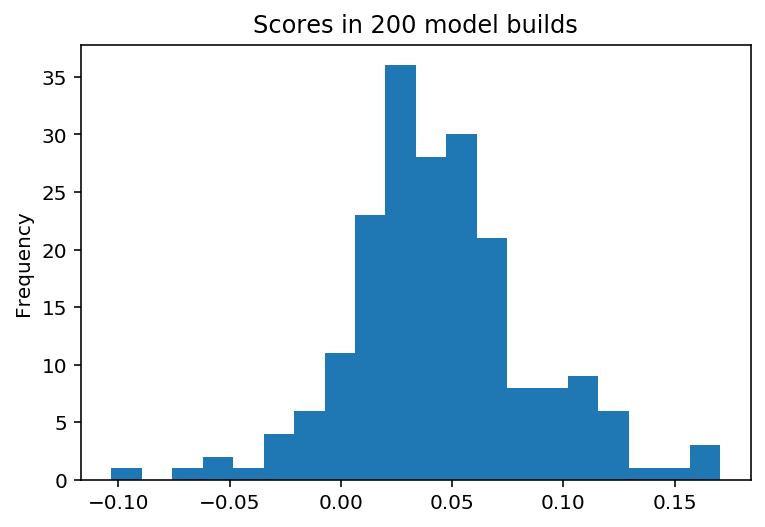

In [36]:
pd.Series(out).plot(kind='hist', title='Scores in 200 model builds',bins=20);

This histogram shows the distribution of the average RMSE where there is a lot of error in this baseline model.

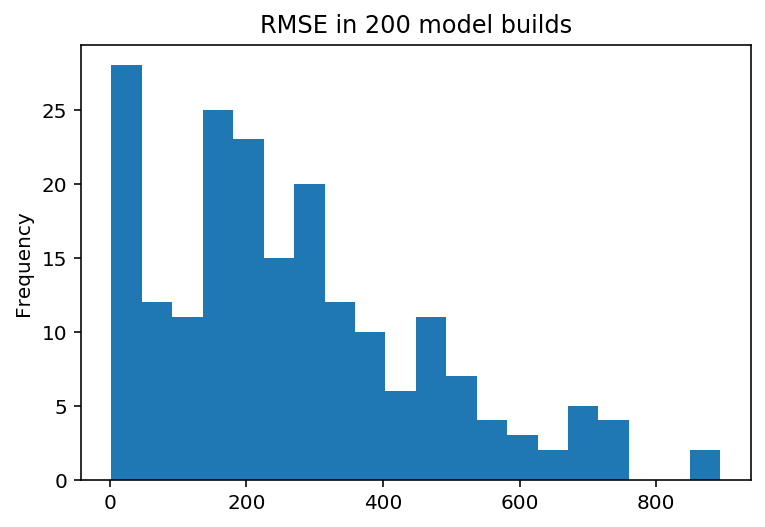

In [37]:
pd.Series(rmse_list).plot(kind='hist', title='RMSE in 200 model builds', bins=20);

## Final Model ## 

For the final model, 'y_final" was used as the baseline and the column 'CAUSE.CATEGORY' was added as a feature because the severity of the power outage can be partically demined by what caused the power outage. 

In [38]:
X_final = outage[['CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW', 'CLIMATE.CATEGORY','MONTH','CLIMATE.REGION', 'CAUSE.CATEGORY']]
y_final = outage['OUTAGE.DURATION']
y_final = y_final.fillna(0)

This code separates the data types between the object types and numerical types.

In [40]:
types_final = X_final.dtypes
categories_final = types_final.loc[types_final == np.object].index
nums_final = types_final.loc[types_final != np.object].index
types_final

CUSTOMERS.AFFECTED    float64
DEMAND.LOSS.MW        float64
CLIMATE.CATEGORY       object
MONTH                  object
CLIMATE.REGION         object
CAUSE.CATEGORY         object
dtype: object

Here is the final, improved model. The same steps are done as the baseline for the nominal categories not including 'CAUSE.CATEGORY'. For the nominal category 'CAUSE.CATEGORY', principal component analysis is used to minimize possible correlation between its components. For instance, equipment failure and system operability disruption could be similar. Principal component analysis could also prevents over-fitting and reduces the noise. For the quantitative columns, StandardScaler function is added to help account for outliers better and standardizes the data.  